In [11]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
ts = Temperatures(path=None, normalize=True)
window_size = 10
autoencoder_embedding = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

to_tensor = lambda arr: asTorch(arr).to(device)
X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t = map(
    to_tensor,
    (X_train, y_train, X_val, y_val, X_test, y_test)
)

Epoch 01/20 — train MSE: 0.822337
Epoch 02/20 — train MSE: 0.404913
Epoch 03/20 — train MSE: 0.330189
Epoch 04/20 — train MSE: 0.282450
Epoch 05/20 — train MSE: 0.264148
Epoch 06/20 — train MSE: 0.248166
Epoch 07/20 — train MSE: 0.230925
Epoch 08/20 — train MSE: 0.219456
Epoch 09/20 — train MSE: 0.202305
Epoch 10/20 — train MSE: 0.185712
Epoch 11/20 — train MSE: 0.175136
Epoch 12/20 — train MSE: 0.168073
Epoch 13/20 — train MSE: 0.161229
Epoch 14/20 — train MSE: 0.154499
Epoch 15/20 — train MSE: 0.148622
Epoch 16/20 — train MSE: 0.145251
Epoch 17/20 — train MSE: 0.139450
Epoch 18/20 — train MSE: 0.137055
Epoch 19/20 — train MSE: 0.134852
Epoch 20/20 — train MSE: 0.131001


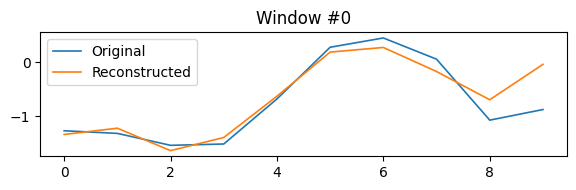

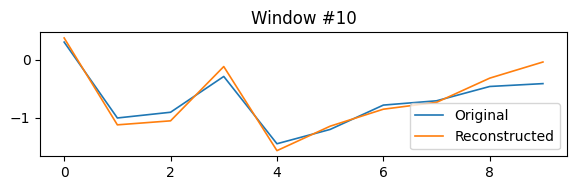

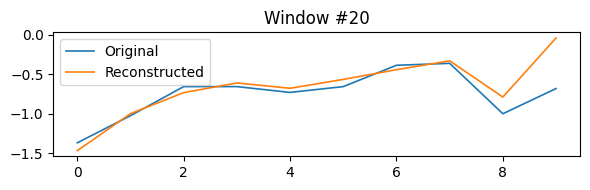

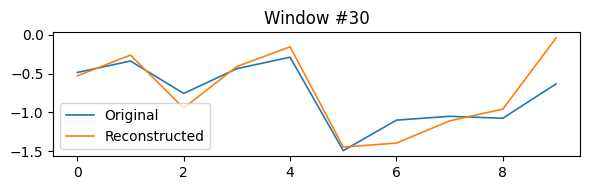

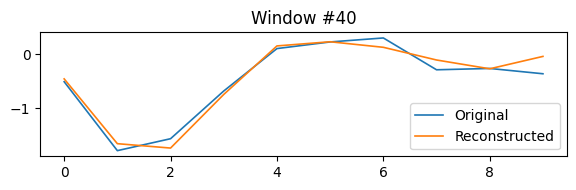

In [15]:
# 2. Prepare DataLoader for training the autoencoder
train_dataset = TensorDataset(X_train_t, X_train_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 3. Instantiate model, loss, optimizer
autoencoder = ConvAutoencoder1D(window_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# 4. Training loop
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    autoencoder.train()
    total_loss = 0.0

    for xb, _ in train_loader:
        xb = xb.to(device, non_blocking=True)
        optimizer.zero_grad()
        recon = autoencoder(xb)
        loss  = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    total_loss /= len(train_loader.dataset)

    # ← Print on every epoch
    print(f"Epoch {epoch:02d}/{num_epochs} — train MSE: {total_loss:.6f}")

# 5. Plot reconstructions on test set
autoencoder.eval()
with torch.no_grad():
    x_test_sub    = X_test_t[:50].to(device)
    reconstructions = autoencoder(x_test_sub)

stride = 10
num_windows = reconstructions.size(0)

for idx in range(0, num_windows, stride):
    orig = X_test_t[idx].squeeze().cpu().numpy()
    recon= reconstructions[idx].squeeze().cpu().numpy()

    plt.figure(figsize=(6, 2))
    plt.plot(orig,  label="Original",      linewidth=1.2)
    plt.plot(recon, label="Reconstructed", linewidth=1.2)
    plt.title(f"Window #{idx}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    #"DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
}

for name, model in forecasters.items():
    print(f"→ Training {name}…")
    model.fit(X_train, y_train)

→ Training ARIMA…
→ Training ExpSmoothing…
→ Training LinearRegression…
→ Training RandomForest…
→ Training SVR…
→ Training GradientBoosting…
→ Training MLP…
→ Training LSTM…
 Epoch 1/30 - Loss: 0.553369
 Epoch 2/30 - Loss: 0.416329
 Epoch 3/30 - Loss: 0.386109
 Epoch 4/30 - Loss: 0.385333
 Epoch 5/30 - Loss: 0.378721
 Epoch 6/30 - Loss: 0.379479
 Epoch 7/30 - Loss: 0.381976
 Epoch 8/30 - Loss: 0.378532
 Epoch 9/30 - Loss: 0.376559
 Epoch 10/30 - Loss: 0.375426
 Epoch 11/30 - Loss: 0.378280
 Epoch 12/30 - Loss: 0.382046
 Epoch 13/30 - Loss: 0.378928
 Epoch 14/30 - Loss: 0.377732
 Epoch 15/30 - Loss: 0.371385
 Epoch 16/30 - Loss: 0.369026
 Epoch 17/30 - Loss: 0.367135
 Epoch 18/30 - Loss: 0.366783
 Epoch 19/30 - Loss: 0.372423
 Epoch 20/30 - Loss: 0.369104
 Epoch 21/30 - Loss: 0.360937
 Epoch 22/30 - Loss: 0.357678
 Epoch 23/30 - Loss: 0.366457
 Epoch 24/30 - Loss: 0.352562
 Epoch 25/30 - Loss: 0.346772
 Epoch 26/30 - Loss: 0.349014
 Epoch 27/30 - Loss: 0.350091
 Epoch 28/30 - Loss: 0.3

In [17]:
# Clear previous RoCs
for model in forecasters.values():
    model.roc.clear()

# Build RoCs
for idx, window in enumerate(X_val):
    # Turn window into a (1,1,L) tensor for prediction
    window_t = asTorch(window).unsqueeze(0)  # shape: (1,1,window_size)

    # 1) Pick best forecaster by raw-window MSE
    errors = {}
    for name, model in forecasters.items():
        y_pred = model.predict(window)
        errors[name] = mean_squared_error([y_val[idx]], [y_pred])
    winner = min(errors, key=errors.get)

    # 2) Build the vector to store
    if autoencoder_embedding:
        # get bottleneck, squeeze batch, then flatten to 1-D
        vec = autoencoder.encode(window).view(-1)
    else:
        # raw window: NumPy → torch → flatten
        vec = torch.from_numpy(window).float().view(-1)

    # 3) Detach & CPU it to keep RoC lightweight
    vec = vec.detach().cpu()

    # 4) Append the 1-D tensor
    forecasters[winner].roc.append(vec)

    print(f"Window {idx:3d} → best model = {winner}  (error = {errors[winner]:.4f})")

# Print RoC sizes
print("\nRoC sizes:")
for name, model in forecasters.items():
    print(f"  {name:<18} {len(model.roc)} entries")

Window   0 → best model = LSTM  (error = 0.0034)
Window   1 → best model = RandomForest  (error = 0.0489)
Window   2 → best model = LinearRegression  (error = 0.1683)
Window   3 → best model = LinearRegression  (error = 0.0042)
Window   4 → best model = RandomForest  (error = 0.2894)
Window   5 → best model = MLP  (error = 0.0077)
Window   6 → best model = RandomForest  (error = 0.2815)
Window   7 → best model = LSTM  (error = 0.0000)
Window   8 → best model = GradientBoosting  (error = 0.0005)
Window   9 → best model = MLP  (error = 0.0740)
Window  10 → best model = ARIMA  (error = 0.0001)
Window  11 → best model = RandomForest  (error = 0.0511)
Window  12 → best model = ARIMA  (error = 0.0022)
Window  13 → best model = CNNLSTM  (error = 0.0639)
Window  14 → best model = RandomForest  (error = 0.2247)
Window  15 → best model = RandomForest  (error = 0.0006)
Window  16 → best model = LSTM  (error = 0.0108)
Window  17 → best model = ARIMA  (error = 0.0010)
Window  18 → best model = MLP 

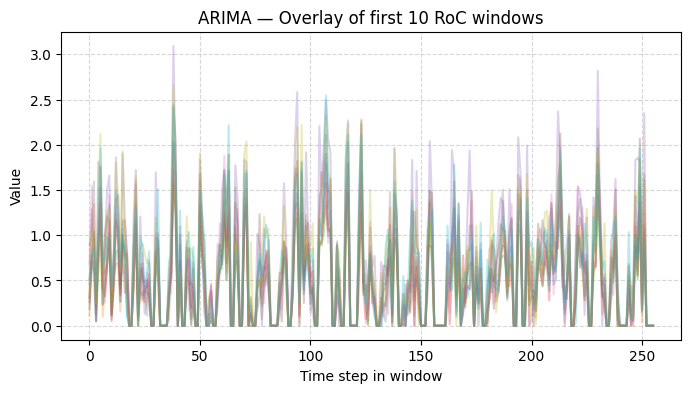

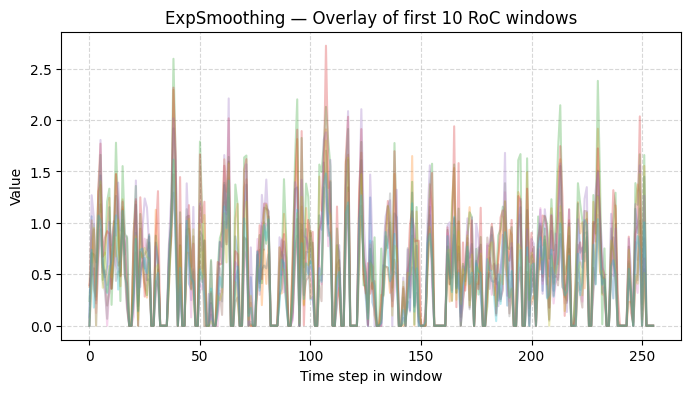

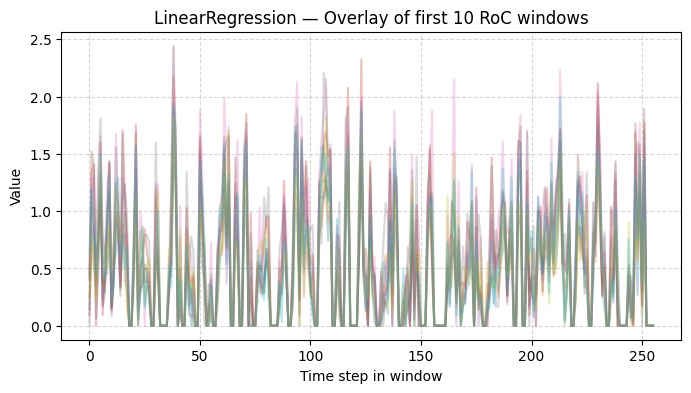

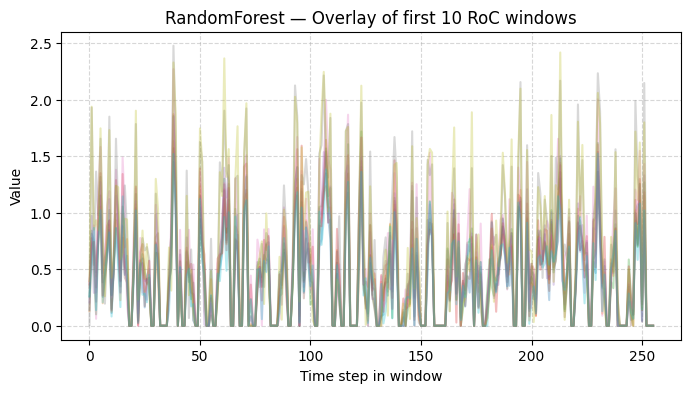

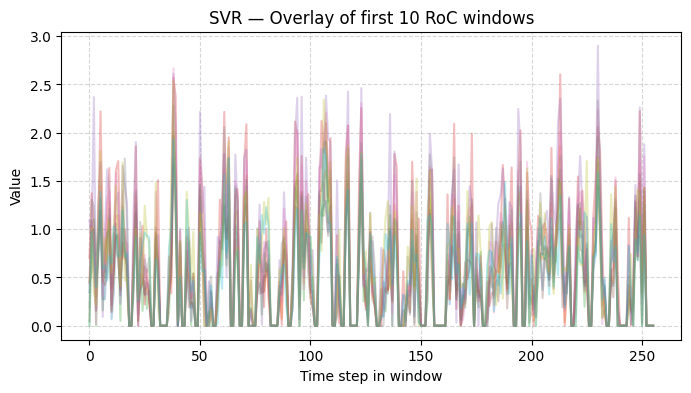

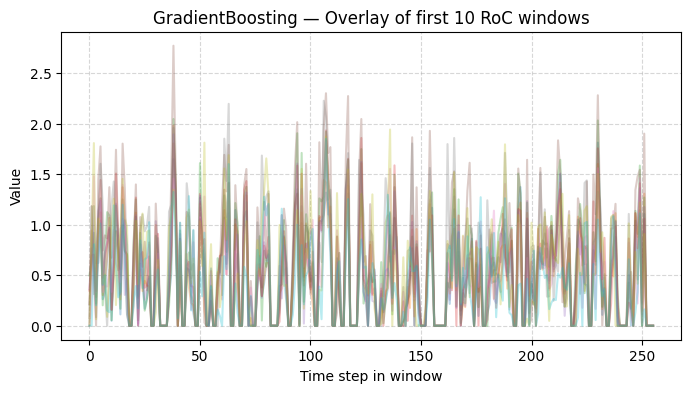

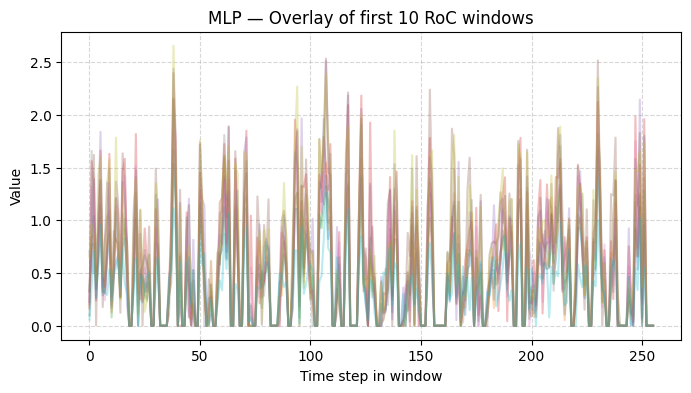

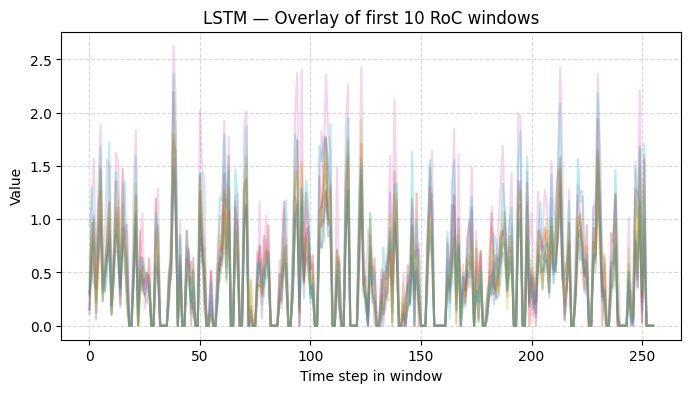

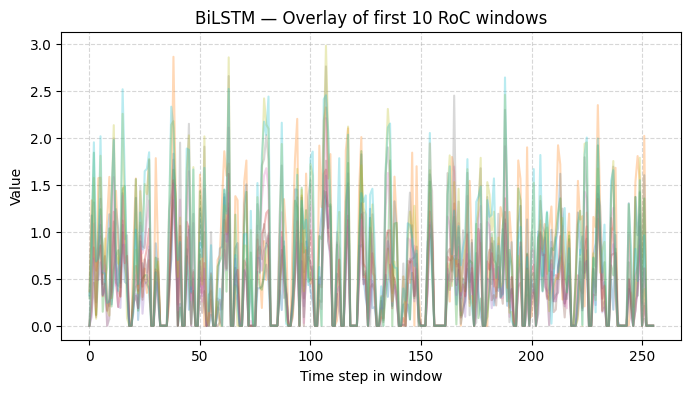

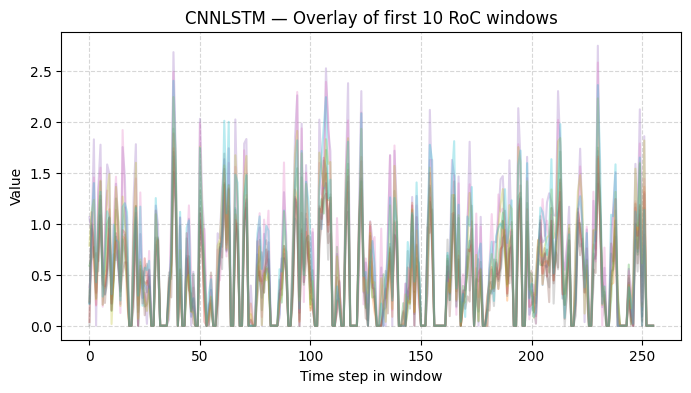

In [18]:
num_to_plot = 10  # how many windows to overlay per model

for name, model in forecasters.items():
    wins = model.roc[:num_to_plot]  # wins are now the actual windows, not indices
    if not wins:
        print(f"{name}: no RoC windows to plot.")
        continue

    plt.figure(figsize=(8, 4))
    for w in wins:
        plt.plot(w, alpha=0.3)  # plot the window directly

    plt.title(f"{name} — Overlay of first {len(wins)} RoC windows")
    plt.xlabel("Time step in window")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [19]:
import torch.nn.functional as F  # make sure this is imported at top

metrics = ["euclidean", "manhattan", "cosine"]
results = {}

for metric in metrics:
    truths = []
    forecasts = []

    for i in range(X_test_t.size(0)):
        window_t = X_test_t[i].unsqueeze(0)  # shape: (1,1,window_size)
        y_true = y_test_t[i].item()

        # Build the flat query vector
        if autoencoder_embedding:
            query = autoencoder.encode(window_t.squeeze(0)).view(-1)
        else:
            query = window_t.squeeze(0).view(-1)

        # 1) Find best forecaster by distance in RoC
        best_dist = float("inf")
        best_name = None
        for name, model in forecasters.items():
            # stack RoC vectors and move to the same device as query
            stack = torch.stack(model.roc).to(query.device)

            if metric == "euclidean":
                dists = torch.norm(stack - query.unsqueeze(0), dim=1)
            elif metric == "manhattan":
                dists = torch.sum(torch.abs(stack - query.unsqueeze(0)), dim=1)
            else:  # cosine
                dists = 1 - F.cosine_similarity(stack, query.unsqueeze(0), dim=1)

            min_dist = dists.min().item()
            if min_dist < best_dist:
                best_dist, best_name = min_dist, name

        # Forecast: convert tensor to CPU numpy array first
        arr = (
            window_t
            .squeeze(0)       # drop batch dim
            .detach()         # unhook from computation graph
            .cpu()            # move to CPU
            .numpy()          # to NumPy
            .reshape(1, -1)   # sklearn expects 2-D
        )
        pred_arr = forecasters[best_name].predict(arr)
        y_pred = float(pred_arr)  # works for scalar or length-1 array

        truths.append(y_true)
        forecasts.append(y_pred)

    # Compute & store overall MSE for this metric
    results[metric] = mean_squared_error(truths, forecasts)
    print(f"Test MSE ({metric}): {results[metric]:.6f}")

# Summary
print(f"\nParameters:\nDataset: {ts}\nwindow_size = {window_size}\nautoencoder_embedding = {autoencoder_embedding}")
print("\nTest MSE by metric:")
for m, v in results.items():
    print(f"  {m:<9} → {v:.6f}")


Test MSE (euclidean): 0.375125
Test MSE (manhattan): 0.371628
Test MSE (cosine): 0.371961

Parameters:
Dataset: <data.temperatures.Temperatures object at 0x000002411B3D1D90>
window_size = 10
autoencoder_embedding = True

Test MSE by metric:
  euclidean → 0.375125
  manhattan → 0.371628
  cosine    → 0.371961


In [20]:
# Baseline Test MSE per Forecaster (with proper CPU↔NumPy conversion)
print("Baseline Test MSE per Forecaster:")

# True values on CPU/NumPy
truths = y_test_t.cpu().numpy()

for name, model in forecasters.items():
    preds = []
    for window in X_test_t:
        # window: (1, window_size) tensor on GPU or CPU
        window_batch = window.unsqueeze(0)                # → shape (1,1,window_size)
        arr = (
            window_batch
            .detach()                                     # unlink from autograd graph
            .cpu()                                        # move to CPU
            .numpy()                                      # convert to NumPy
            .reshape(1, -1)                               # sklearn expects 2D array
        )
        # model.predict returns either a scalar array or a scalar
        y_pred = float(model.predict(arr))
        preds.append(y_pred)

    mse = mean_squared_error(truths, preds)
    print(f"{name:<18} MSE: {mse:.6f}")


Baseline Test MSE per Forecaster:
ARIMA              MSE: 0.439483
ExpSmoothing       MSE: 0.407071
LinearRegression   MSE: 0.330774
RandomForest       MSE: 0.375865
SVR                MSE: 0.321832
GradientBoosting   MSE: 0.339396
MLP                MSE: 0.322001
LSTM               MSE: 0.343468
BiLSTM             MSE: 0.346941
CNNLSTM            MSE: 0.420573
